# Generative Adversarial Network Tutorial 00

In particle physics, Generative Adversarial Networks hold a lot of promise for studying data/MC differences.  In principle, the physics tools used for simulation of particle interaction data are quite good, but they are never perfect.  Additionally, they are always imperfect in difficult to model ways.  Many experiments spend a lot of time studying the differences between the output of their simulation and their real detector data, and a deep network that can learn these differences is really useful for making progress.

In this tutorial, I'll cover some basics of generative adversarial networks with very simple feed-forward neural networks (not even convolutional) as a demonstration of the basic techniques of GANs.  You can read the original paper on GANs here: https://arxiv.org/abs/1406.2661.  The basic idea is you train two networks to compete with each other.  The first (called the discriminator) makes a decision on whether or not the images it's looking at are real or fake.  The second (called the generator) tries to generate fake images from random noise to fool the discriminator.

In the years since the original paper came out, GANs have grown increasinly more sophisticated and impressive, especially with the advent of the Deep Convolutional Generative Adversarial Network (DCGAN, original paper: https://arxiv.org/abs/1511.06434).  For this tutorial, we're going to eschew all of the recent advances to make a GAN that can generate artificial digits based on the mnist data set.  By stripping the networks down to their basics, it's easier to focus on the core aspects of the loss function and outputs, and to avoid the complications of training on GPUs, etc.

## MNIST data set

The mnist data set is one of the most famous collections of labeled images that exists.  You can read all about it at the original website (http://yann.lecun.com/exdb/mnist/), but it has a few nice advantages that make it ideal for learning:
 * It's open, and has convient wrappers in many languages (we'll use tensorflows soon)
 * It's a large data set (60k training images) but each image is small (28x28)
 * The data has been preprocessed to center images of digits and make them easier to use
 
Basically, you can focus on the fundamentals with this data set, which is why we'll use it here.  Some examples of loading it with tensorflow (more here: https://www.tensorflow.org/get_started/mnist/beginners)

In [1]:
import tensorflow as tf
import numpy
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist = input_data.read_data_sets("MNIST_data", one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
mnist_images, mnist_labels = mnist.train.next_batch(batch_size=5)

Here, we've loaded the mnist data from the tensorflow helper class, and asked for the next batch of images and labels.  Let's view those to see what the data looks like before delving into the network:

In [4]:
print "mnist_images.shape: {}".format(mnist_images.shape)
print "mnist_labels.shape: {}".format(mnist_labels.shape)

mnist_images.shape: (5, 784)
mnist_labels.shape: (5,)


As expected, variables are arrays with the outermost dimension equal to 5.  The images, though, comes unpacked as a 1D array per image instead of a 2D array.  We can reshape this to what we're more familar with, since we know mnist images are 28x28:

In [5]:
mnist_images = numpy.reshape(mnist_images, (-1, 28, 28)) # -1 can be used as a placeholder for batch size here

In [6]:
print "mnist_images.shape: {}".format(mnist_images.shape)


mnist_images.shape: (5, 28, 28)


Matplotlib gives a good interface for viewing these images in a notebook (or even in general, in python):

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

This image is labeled as 3


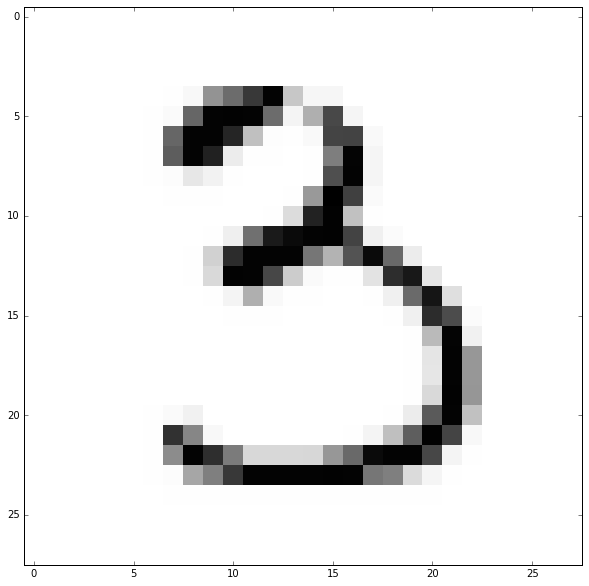

In [8]:
index = numpy.random.randint(5)
fig = plt.figure(figsize=(10,10))
plt.imshow(mnist_images[index], cmap="Greys", interpolation="none")
print "This image is labeled as {}".format(mnist_labels[index])
plt.show()

Drawn like this, you can see each individual pixel clearly.  It's not a high resolution image, but you can clearly tell what the digit is!

## Building a model for a GAN

We'll start to put together a network for the GAN, first by defining some useful constants that we'll need to call on multiple times:

In [9]:
BASE_LEARNING_RATE = 0.000001
BATCH_SIZE=64 # Keep this even
LOGDIR="./mnist_gan_logs/"

Additionally, let's make sure we have the same graph by defining it:

In [10]:
tf.reset_default_graph()
g = tf.Graph()

Set up the placeholders for the input variables.  We'll need to input both real images and random noise, so make a placeholder for both:

In [11]:
with g.as_default():
    # Input noise to the generator:
    noise_tensor = tf.placeholder(tf.float32, [int(BATCH_SIZE*0.5), 10*10], name="noise")
    fake_input   = tf.reshape(noise_tensor, (tf.shape(noise_tensor)[0], 10,10, 1))

    # Placeholder for the discriminator input:
    real_flat  = tf.placeholder(tf.float32, [int(BATCH_SIZE*0.5), 784], name='x')
    # label_tensor = tf.placeholder(tf.float32, [BATCH_SIZE, 1], name='labels')
    real_images  = tf.reshape(real_flat, (tf.shape(real_flat)[0], 28, 28, 1))
    
    # We augment the input to the discriminator with gaussian noise
    # This makes it harder for the discriminator to do it's job, preventing
    # it from always "winning" the GAN min/max contest
    real_noise = tf.placeholder(tf.float32, [int(BATCH_SIZE*0.5), 28, 28, 1], name="real_noise")
    fake_noise = tf.placeholder(tf.float32, [int(BATCH_SIZE*0.5), 28, 28, 1], name="fake_noise")

    real_images = real_noise + real_images
    

Notice how the input tensors (noise_tensor, real_images) are shaped in the 'flattened' way: (N/2, 100) for noise, (N/2, 784) for real images.  This lets me input the mnist images directly to tensorflow, as well as the noise.  They are then reshaped to be like tensorflow images (Batch, H, W, Filters).

### Image Discriminator:

Make a function to build the discriminator, using fully connected networks.  Note that a convolutional layer with the stride equal to the image size *is* a fully connected layer.

In [12]:
def build_discriminator(input_tensor, reuse,reg=0.1):
    # Use scoping to keep the variables nicely organized in the graph.
    # Scoping is good practice always, but it's *essential* here as we'll see later on
    with tf.variable_scope("mnist_discriminator", reuse=reuse):
        x = tf.layers.conv2d(input_tensor,
                             filters=128, #Connecting to 128 output neurons, each it's own filter
                             kernel_size=[28,28], # Use the size of the mnist images to make this FC
                             strides=(1, 1),
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=reg),
                             name="fully_connected_1")
        # Apply a non linearity:
        x = tf.nn.relu(x)
        # That maps to a hidden layer, shape is (B, 1, 1, 128), let's now map to a single output
        x = tf.layers.conv2d(x,
                             filters=1,         #Connecting to 1 output neuron
                             kernel_size=[1,1], 
                             strides=(1, 1),
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=reg),
                             name="fully_connected_2")
        
        # Since we want to predict "real" or "fake", an output of 0 or 1 is desired.  sigmoid is perfect for this:
        x = tf.nn.sigmoid(x, name="discriminator_sigmoid")
        #Reshape this to bring it down to just one output per image:
        x = tf.reshape(x, (x.get_shape().as_list()[0],))
        return x

In [13]:
with g.as_default():
    real_image_logits = build_discriminator(real_images, reuse=False,reg=0.2)

Now we can define a function to generate random images from noise:

In [14]:
def build_generator(input_tensor, reg=0.2):
    # Again, scoping is essential here:
    with tf.variable_scope("mnist_generator"):
        # Input is Bx10x10x1, let's use two hidden layers this time to upsample to 28x28:
        x = tf.layers.conv2d(input_tensor,
                             filters=256, #256 is essentially a 16x16 image
                             kernel_size=[10,10], # Use the size of the mnist images to make this FC
                             strides=(1, 1),
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=reg),
                             name="fully_connected_1")
        
        # Apply nonlinearity, this time using a 'leaky relu':
        x = tf.maximum(x, 0.1*x)
        
        
        # Another fully connected layer, no change to resolution yet:
        x = tf.layers.conv2d(x,
                             filters=256, #256 is essentially a 16x16 image
                             kernel_size=[1,1], # Use the size of the mnist images to make this FC
                             strides=(1, 1),
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=reg),
                             name="fully_connected_2")
        
        # Apply nonlinearity, this time using a 'leaky relu':
        x = tf.maximum(x, 0.1*x)
        
        
        
        # Final layer, step up to "full" resolution and then reshape the tensor:
        x = tf.layers.conv2d(x,
                             filters=784, #784 is a 28x28 image
                             kernel_size=[1,1], # Use the size of the mnist images to make this FC
                             strides=(1, 1),
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=reg),
                             name="fully_connected_3")
        
        # Reshape to match mnist images:
        x = tf.reshape(x, (-1, 28, 28, 1))
        
        # The final non linearity applied here is to map the images onto the [-1,1] range.
        x = tf.nn.tanh(x, name="generator_tanh")
        return x

In [15]:
with g.as_default():
    fake_images = build_generator(fake_input) 

We also need to be able to run the discriminator on the fake images, so set that up too.  Since it trains on both real and fake images, set reuse=True here:

In [16]:
with g.as_default():
    fake_image_logits = build_discriminator(fake_images, reuse=True, reg=0.2)

### Loss functions

We can now define our loss functions.  Note that we have to define the loss function for the generator and discriminator seperately:

In [17]:
# Build the loss functions:
with g.as_default():
    with tf.name_scope("cross_entropy") as scope:

        #Discriminator loss on real images (classify as 1):
        d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_image_logits,
            labels = tf.ones_like(real_image_logits)))
        #Discriminator loss on fake images (classify as 0):
        d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_image_logits,
            labels = tf.zeros_like(fake_image_logits)))

        # Total discriminator loss is the sum:
        d_loss_total = d_loss_real + d_loss_fake

        # This is the adverserial step: g_loss tries to optimize fake_logits to one,
        # While d_loss_fake tries to optimize fake_logits to zero.
        g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_image_logits,
            labels = tf.ones_like(fake_image_logits)))
        
        # This code is useful if you'll use tensorboard to monitor training:
        d_loss_summary = tf.summary.scalar("Discriminator_Real_Loss", d_loss_real)
        d_loss_summary = tf.summary.scalar("Discriminator_Fake_Loss", d_loss_fake)
        d_loss_summary = tf.summary.scalar("Discriminator_Total_Loss", d_loss_total)
        d_loss_summary = tf.summary.scalar("Generator_Loss", g_loss)


It's also useful to compute accuracy, just to see how the training is going:

In [18]:
with g.as_default():
    with tf.name_scope("accuracy") as scope:
        # Compute the discriminator accuracy on real data, fake data, and total:
        accuracy_real  = tf.reduce_mean(tf.cast(tf.equal(tf.round(real_image_logits), 
                                                         tf.ones_like(real_image_logits)), 
                                                tf.float32))
        accuracy_fake  = tf.reduce_mean(tf.cast(tf.equal(tf.round(fake_image_logits), 
                                                         tf.zeros_like(fake_image_logits)), 
                                                tf.float32))
        
        total_accuracy = 0.5*(accuracy_fake +  accuracy_real)
    
        # Again, useful for tensorboard:
        acc_real_summary = tf.summary.scalar("Real_Accuracy", accuracy_real)
        acc_real_summary = tf.summary.scalar("Fake_Accuracy", accuracy_fake)
        acc_real_summary = tf.summary.scalar("Total_Accuracy", total_accuracy)

### Independant Optimizers

To allow the generator and discriminator to compete and update seperately, we use two distinct optimizers.  This step is why it was essential earlier to have the scopes different for the generator and optimizer: we can select all variables in each scope to go to their own optimizer.  So, even though the generator loss calculation runs the discriminator, the update step for the generator **only** affects the variables inside the generator

In [19]:
with g.as_default():
    with tf.name_scope("training") as scope:
        # Global steps are useful for restoring training:
        global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')

        # Make sure the optimizers are only operating on their own variables:
        
        all_variables      = tf.trainable_variables()
        discriminator_vars = [v for v in all_variables if v.name.startswith('mnist_discriminator/')]
        generator_vars     = [v for v in all_variables if v.name.startswith('mnist_generator/')]
    
    
        discriminator_optimizer = tf.train.AdamOptimizer(BASE_LEARNING_RATE, 0.5).minimize(
            d_loss_total, global_step=global_step, var_list=discriminator_vars)
        generator_optimizer     = tf.train.AdamOptimizer(BASE_LEARNING_RATE, 0.5).minimize(
            g_loss, global_step=global_step, var_list=generator_vars)


### Image snapshots

It's useful to snapshot images into tensorboard to see how things are going, as well:

In [20]:
with g.as_default():
    tf.summary.image('fake_images', fake_images, max_outputs=4)
    tf.summary.image('real_images', real_images, max_outputs=4)


## Training the networks

There are lots of philosophys on training GANs.  Here, we'll do something simple and just alternate updates. To save the network and keep track of training variables, set up a summary writer:

In [ ]:
with g.as_default():
    merged_summary = tf.summary.merge_all()

    # Set up a saver:
    train_writer = tf.summary.FileWriter(LOGDIR)

Set up a session for training using an interactive session:

In [ ]:
with g.as_default():
    sess = tf.InteractiveSession()
    RESTORE=False
    if not RESTORE:
        sess.run(tf.global_variables_initializer())
        train_writer.add_graph(sess.graph)
        saver = tf.train.Saver()
    else: 
        latest_checkpoint = tf.train.latest_checkpoint(LOGDIR+"/checkpoints/")
        print "Restoring model from {}".format(latest_checkpoint)
        saver = tf.train.Saver()
        saver.restore(sess, latest_checkpoint)
        
        
        
    print "Begin training ..."
    # Run training loop
    for i in xrange(50000):
        step = sess.run(global_step)

        # Receive data (this will hang if IO thread is still running = this
        # will wait for thread to finish & receive data)
        
        sigma = max(1.0*(40000. - step) / (40000), 0.01)

        # Update the generator:
        # Prepare the input to the networks:
        fake_input = numpy.random.uniform(-1, 1, (int(BATCH_SIZE*0.5), 10*10))
        real_data, label = mnist.train.next_batch(int(BATCH_SIZE*0.5))
        real_data = 2*(real_data - 0.5)
        
        real_noise_addition = numpy.random.normal(scale=sigma,size=(int(BATCH_SIZE*0.5),28,28,1))
        fake_noise_addition = numpy.random.normal(scale=sigma,size=(int(BATCH_SIZE*0.5),28,28,1))
        
        
        [  acc_fake, _ ] = sess.run(
            [accuracy_fake, 
             generator_optimizer], 
            feed_dict = {noise_tensor: fake_input,
                         real_flat : real_data,
                         real_noise: real_noise_addition,
                         fake_noise: fake_noise_addition})

        # Update the discriminator:
        # Prepare the input to the networks:
        fake = numpy.random.uniform(-1, 1, (int(BATCH_SIZE*0.5), 10*10))
        real_data, label = mnist.train.next_batch(int(BATCH_SIZE*0.5))
        real_data = 2*(real_data - 0.5)
        [generated_mnist, _] = sess.run([fake_images, 
                                        discriminator_optimizer], 
                                        feed_dict = {noise_tensor : fake_input,
                                                     real_flat : real_data,
                                                     real_noise: real_noise_addition,
                                                     fake_noise: fake_noise_addition})




        [summary, g_l, acc_fake, d_l_r, acc] = sess.run(
            [merged_summary, g_loss, accuracy_fake,
             d_loss_real, total_accuracy],
            feed_dict = {noise_tensor : fake,
                         real_flat : real_data,
                         real_noise: real_noise_addition,
                         fake_noise: fake_noise_addition})


        train_writer.add_summary(summary, step)


        if step != 0 and step % 500 == 0:
            saver.save(
                sess,
                LOGDIR+"/checkpoints/save",
                global_step=step)


        # train_writer.add_summary(summary, i)
        # sys.stdout.write('Training in progress @ step %d\n' % (step))
        if step % 50 == 0:
            print 'Training in progress @ global_step %d, g_loss %g, d_loss %g accuracy %g' % (step, g_l, d_l_r, acc)


Begin training ...
Training in progress @ global_step 0, g_loss 0.473839, d_loss 0.474636 accuracy 0.234375
Training in progress @ global_step 50, g_loss 0.473827, d_loss 0.464991 accuracy 0.46875
Training in progress @ global_step 100, g_loss 0.473856, d_loss 0.45017 accuracy 0.53125
Training in progress @ global_step 150, g_loss 0.473781, d_loss 0.447407 accuracy 0.5
Training in progress @ global_step 200, g_loss 0.473789, d_loss 0.434797 accuracy 0.5
Training in progress @ global_step 250, g_loss 0.473789, d_loss 0.426994 accuracy 0.515625
Training in progress @ global_step 300, g_loss 0.473739, d_loss 0.423329 accuracy 0.53125
Training in progress @ global_step 350, g_loss 0.473734, d_loss 0.418147 accuracy 0.515625
Training in progress @ global_step 400, g_loss 0.473724, d_loss 0.407274 accuracy 0.515625
Training in progress @ global_step 450, g_loss 0.473785, d_loss 0.402142 accuracy 0.578125
Training in progress @ global_step 500, g_loss 0.473679, d_loss 0.395108 accuracy 0.5
Tr

Training in progress @ global_step 4700, g_loss 0.471726, d_loss 0.317888 accuracy 0.5
Training in progress @ global_step 4750, g_loss 0.471581, d_loss 0.317089 accuracy 0.5
Training in progress @ global_step 4800, g_loss 0.471761, d_loss 0.317041 accuracy 0.5
Training in progress @ global_step 4850, g_loss 0.471887, d_loss 0.317794 accuracy 0.5
Training in progress @ global_step 4900, g_loss 0.471679, d_loss 0.317141 accuracy 0.5
Training in progress @ global_step 4950, g_loss 0.471837, d_loss 0.317434 accuracy 0.5
Training in progress @ global_step 5000, g_loss 0.472023, d_loss 0.318543 accuracy 0.5
Training in progress @ global_step 5050, g_loss 0.471893, d_loss 0.317199 accuracy 0.5
Training in progress @ global_step 5100, g_loss 0.471875, d_loss 0.31708 accuracy 0.5
Training in progress @ global_step 5150, g_loss 0.472077, d_loss 0.317486 accuracy 0.5
Training in progress @ global_step 5200, g_loss 0.471978, d_loss 0.317503 accuracy 0.5
Training in progress @ global_step 5250, g_l

Training in progress @ global_step 9300, g_loss 0.472992, d_loss 0.318825 accuracy 0.546875
Training in progress @ global_step 9350, g_loss 0.473149, d_loss 0.318372 accuracy 0.53125
Training in progress @ global_step 9400, g_loss 0.473417, d_loss 0.319422 accuracy 0.625
Training in progress @ global_step 9450, g_loss 0.473004, d_loss 0.319936 accuracy 0.53125
Training in progress @ global_step 9500, g_loss 0.472659, d_loss 0.318699 accuracy 0.546875
Training in progress @ global_step 9550, g_loss 0.473236, d_loss 0.318913 accuracy 0.546875
Training in progress @ global_step 9600, g_loss 0.472767, d_loss 0.319384 accuracy 0.515625
Training in progress @ global_step 9650, g_loss 0.472759, d_loss 0.319226 accuracy 0.5
Training in progress @ global_step 9700, g_loss 0.472972, d_loss 0.319111 accuracy 0.546875
Training in progress @ global_step 9750, g_loss 0.472843, d_loss 0.319181 accuracy 0.515625
Training in progress @ global_step 9800, g_loss 0.472609, d_loss 0.319804 accuracy 0.5
Tra

Training in progress @ global_step 13950, g_loss 0.465212, d_loss 0.322889 accuracy 0.5
Training in progress @ global_step 14000, g_loss 0.464886, d_loss 0.322247 accuracy 0.5
Training in progress @ global_step 14050, g_loss 0.465196, d_loss 0.323449 accuracy 0.5
Training in progress @ global_step 14100, g_loss 0.464485, d_loss 0.323914 accuracy 0.5
Training in progress @ global_step 14150, g_loss 0.465078, d_loss 0.322771 accuracy 0.5
Training in progress @ global_step 14200, g_loss 0.464334, d_loss 0.32327 accuracy 0.5
Training in progress @ global_step 14250, g_loss 0.464704, d_loss 0.32237 accuracy 0.5
Training in progress @ global_step 14300, g_loss 0.464828, d_loss 0.322945 accuracy 0.5
Training in progress @ global_step 14350, g_loss 0.46454, d_loss 0.323497 accuracy 0.5
Training in progress @ global_step 14400, g_loss 0.464028, d_loss 0.322406 accuracy 0.5
Training in progress @ global_step 14450, g_loss 0.464795, d_loss 0.323905 accuracy 0.5
Training in progress @ global_step 

Training in progress @ global_step 18650, g_loss 0.460807, d_loss 0.329826 accuracy 0.5
Training in progress @ global_step 18700, g_loss 0.460185, d_loss 0.328816 accuracy 0.5
Training in progress @ global_step 18750, g_loss 0.460347, d_loss 0.3285 accuracy 0.5
Training in progress @ global_step 18800, g_loss 0.460069, d_loss 0.329702 accuracy 0.5
Training in progress @ global_step 18850, g_loss 0.460364, d_loss 0.330372 accuracy 0.5
Training in progress @ global_step 18900, g_loss 0.460647, d_loss 0.332217 accuracy 0.5
Training in progress @ global_step 18950, g_loss 0.460572, d_loss 0.330694 accuracy 0.5
Training in progress @ global_step 19000, g_loss 0.459681, d_loss 0.330113 accuracy 0.5
Training in progress @ global_step 19050, g_loss 0.460147, d_loss 0.331225 accuracy 0.5
Training in progress @ global_step 19100, g_loss 0.459493, d_loss 0.331264 accuracy 0.5
Training in progress @ global_step 19150, g_loss 0.460121, d_loss 0.329348 accuracy 0.5
Training in progress @ global_step

Training in progress @ global_step 23350, g_loss 0.453617, d_loss 0.341321 accuracy 0.5
Training in progress @ global_step 23400, g_loss 0.453533, d_loss 0.340929 accuracy 0.5
Training in progress @ global_step 23450, g_loss 0.453855, d_loss 0.340154 accuracy 0.5
Training in progress @ global_step 23500, g_loss 0.454595, d_loss 0.342926 accuracy 0.5
Training in progress @ global_step 23550, g_loss 0.454406, d_loss 0.341142 accuracy 0.5
Training in progress @ global_step 23600, g_loss 0.454062, d_loss 0.342187 accuracy 0.5
Training in progress @ global_step 23650, g_loss 0.454041, d_loss 0.342445 accuracy 0.5
Training in progress @ global_step 23700, g_loss 0.454047, d_loss 0.342953 accuracy 0.5
Training in progress @ global_step 23750, g_loss 0.454129, d_loss 0.341285 accuracy 0.5
Training in progress @ global_step 23800, g_loss 0.453534, d_loss 0.342161 accuracy 0.5
Training in progress @ global_step 23850, g_loss 0.453046, d_loss 0.342614 accuracy 0.5
Training in progress @ global_st

Training in progress @ global_step 28050, g_loss 0.450065, d_loss 0.360911 accuracy 0.5
Training in progress @ global_step 28100, g_loss 0.45064, d_loss 0.362326 accuracy 0.5
Training in progress @ global_step 28150, g_loss 0.449214, d_loss 0.361487 accuracy 0.5
Training in progress @ global_step 28200, g_loss 0.448558, d_loss 0.361758 accuracy 0.5
Training in progress @ global_step 28250, g_loss 0.450557, d_loss 0.360929 accuracy 0.5
Training in progress @ global_step 28300, g_loss 0.449272, d_loss 0.362253 accuracy 0.5
Training in progress @ global_step 28350, g_loss 0.448418, d_loss 0.361731 accuracy 0.5
Training in progress @ global_step 28400, g_loss 0.45061, d_loss 0.362108 accuracy 0.5
Training in progress @ global_step 28450, g_loss 0.449694, d_loss 0.361935 accuracy 0.5
Training in progress @ global_step 28500, g_loss 0.449697, d_loss 0.36194 accuracy 0.5
Training in progress @ global_step 28550, g_loss 0.449502, d_loss 0.36202 accuracy 0.5
Training in progress @ global_step 2

Training in progress @ global_step 32750, g_loss 0.450876, d_loss 0.387498 accuracy 0.5
Training in progress @ global_step 32800, g_loss 0.450547, d_loss 0.387868 accuracy 0.5
Training in progress @ global_step 32850, g_loss 0.450461, d_loss 0.389234 accuracy 0.5
Training in progress @ global_step 32900, g_loss 0.450353, d_loss 0.388305 accuracy 0.5
Training in progress @ global_step 32950, g_loss 0.451656, d_loss 0.389261 accuracy 0.5
Training in progress @ global_step 33000, g_loss 0.45194, d_loss 0.39013 accuracy 0.5
Training in progress @ global_step 33050, g_loss 0.451681, d_loss 0.389829 accuracy 0.5
Training in progress @ global_step 33100, g_loss 0.450515, d_loss 0.389409 accuracy 0.5
Training in progress @ global_step 33150, g_loss 0.4513, d_loss 0.390121 accuracy 0.5
Training in progress @ global_step 33200, g_loss 0.451406, d_loss 0.39097 accuracy 0.5
Training in progress @ global_step 33250, g_loss 0.451387, d_loss 0.393034 accuracy 0.5
Training in progress @ global_step 33

Training in progress @ global_step 37450, g_loss 0.46173, d_loss 0.426558 accuracy 0.5
Training in progress @ global_step 37500, g_loss 0.462997, d_loss 0.427473 accuracy 0.5
Training in progress @ global_step 37550, g_loss 0.463477, d_loss 0.42913 accuracy 0.5
Training in progress @ global_step 37600, g_loss 0.463157, d_loss 0.427389 accuracy 0.5
Training in progress @ global_step 37650, g_loss 0.463636, d_loss 0.428417 accuracy 0.5
Training in progress @ global_step 37700, g_loss 0.463212, d_loss 0.427937 accuracy 0.5
Training in progress @ global_step 37750, g_loss 0.463584, d_loss 0.428765 accuracy 0.5
Training in progress @ global_step 37800, g_loss 0.463513, d_loss 0.430782 accuracy 0.5
Training in progress @ global_step 37850, g_loss 0.46322, d_loss 0.43036 accuracy 0.5
Training in progress @ global_step 37900, g_loss 0.463562, d_loss 0.430725 accuracy 0.5
Training in progress @ global_step 37950, g_loss 0.464458, d_loss 0.431623 accuracy 0.5
Training in progress @ global_step 3